In [3227]:
## Titanic Passenger Survival Prediction (Kaggle)
## 0.78947 Score with model ensemble

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os


In [3228]:
# final_fit: 'False' tends to produce better scores
final_fit = True  # True => uses all TRAIN_DATA for machine learning
final_fit = False  # False => uses 80% of TRAIN_DATA for machine learning

# apply_selected_columns: 'False' tends to produce better scores
apply_selected_columns = True # True => focus on a few key values for each feature (e.g. If 'Title' feature has 5 values but 3 of them have major impact, use only 3 values)
apply_selected_columns = False # False => uses all values of each feature


In [3229]:
# cwd = os.getcwd()
# print(cwd)

# Input data files are in "C:\_DataAnalytics\Titanic\input" directory.
inputdir = 'C:\_DataAnalytics\Titanic\input'
inputfilenames = os.listdir(inputdir)
print(inputfilenames)

['gender_submission.csv', 'test.csv', 'train.csv']


#####################################

Read input data (train.csv, test.csv)

#####################################
- train.csv and test.csv have different column sets
- concatenate them from the beginning to commonize columns
and do all the feature processings on the full data

In [3230]:
# Read data files
TRAIN_DATA_zero = pd.read_csv(os.path.join(inputdir, inputfilenames[2]))
TEST_DATA_zero = pd.read_csv(os.path.join(inputdir, inputfilenames[1]))


In [3231]:
TRAIN_DATA_zero.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3232]:
TEST_DATA_zero.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## 🧾 Titanic Dataset Column Descriptions

| Column Name    | Description |
|----------------|-------------|
| **PassengerId** | Unique identifier for each passenger |
| **Survived**    | Survival status (0 = Died, 1 = Survived) ← Target variable |
| **Pclass**      | Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) |
| **Name**        | Full name of the passenger (includes title) |
| **Sex**         | Gender (male, female) |
| **Age**         | Age in years (may contain missing values) |
| **SibSp**       | Number of siblings or spouses aboard |
| **Parch**       | Number of parents or children aboard |
| **Ticket**      | Ticket number |
| **Fare**        | Passenger fare |
| **Cabin**       | Cabin number (many missing values) |
| **Embarked**    | Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

## EDA

In [3233]:
# FULL_DATA =  train + test data
TRAIN_DATA_zero['is_train'] = 1
TEST_DATA_zero['is_train'] = 0
FULL_DATA = pd.concat([TRAIN_DATA_zero, TEST_DATA_zero])

# Verify that no PassengerId's are common
is_duplicate = FULL_DATA['PassengerId'].duplicated().any()
print(f"Overlaps in PassengerId: {is_duplicate}")


Overlaps in PassengerId: False


In [3234]:
FULL_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  is_train     1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


In [3235]:

FULL_DATA['Survived'] = FULL_DATA['Survived'].fillna(0).astype('int64')
FULL_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  is_train     1309 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 143.2+ KB


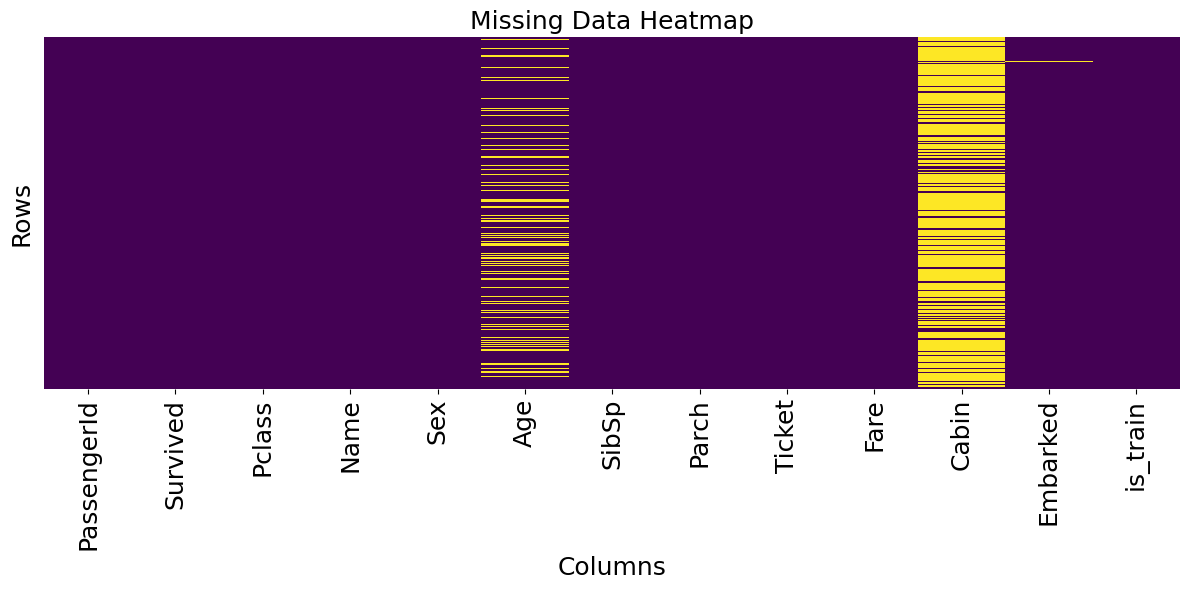

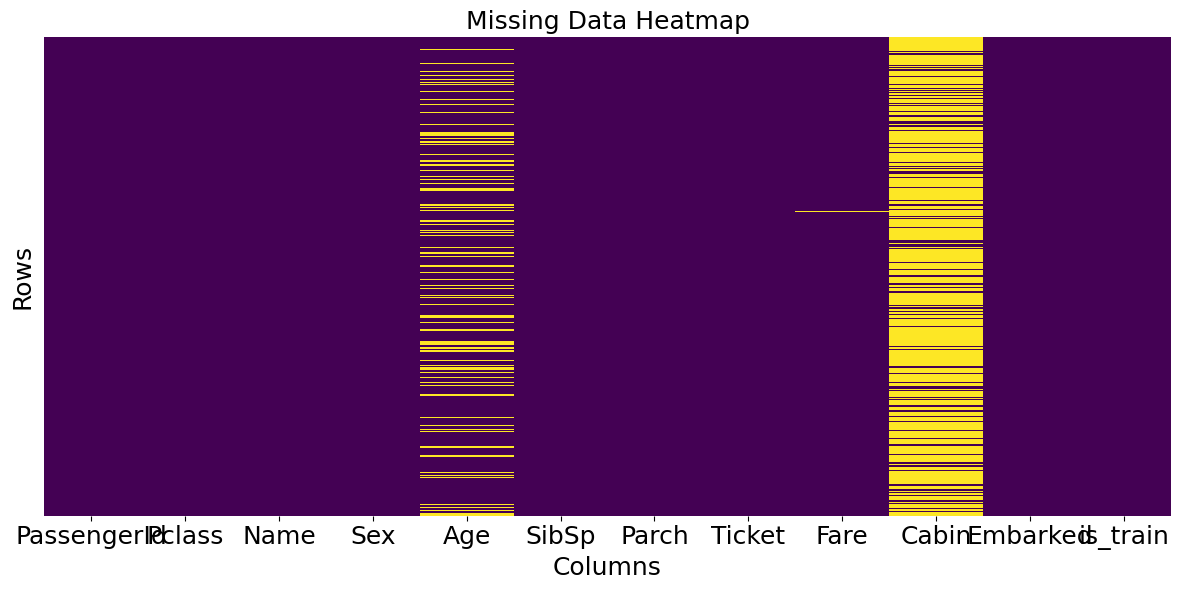

In [3236]:
# Check missing values

def heatmap_missing_values(ldf, plotwidth = 12, plotheight=6):
    plt.figure(figsize=(plotwidth, plotheight))
    sns.heatmap(ldf.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Missing Data Heatmap', fontsize=18)
    plt.xlabel('Columns', fontsize=18)
    plt.ylabel('Rows', fontsize=18)
    plt.xticks(fontsize=18)
    plt.tight_layout()
    plt.show()

heatmap_missing_values(TRAIN_DATA_zero)
heatmap_missing_values(TEST_DATA_zero)

'Age' column has many missing entries
It shall be filled,
but not with the average of all passengers.
Some features may be used to guess the age more cleverly,
like, distinguishing 'Miss' and 'Mrs.' 

In [3237]:
# Check total survival rate
print("Total Survival Rate = ", TRAIN_DATA_zero['Survived'].mean())

Total Survival Rate =  0.3838383838383838


In [3238]:
# Will Check survival rates and sample counts for each feature

# Define a function
def check_survival_rate(mydf, mycolumnlist, lengthcap=True):
    for col in mycolumnlist:
        local_df = mydf.groupby(col)['Survived'].agg(['mean', 'count']).reset_index()
        if lengthcap==True:
            if len(local_df) < 10:
                print(local_df)
        else:
            print(local_df)


In [3239]:
# Check survival rates and sample counts (1)
col_list = TRAIN_DATA_zero.columns

check_survival_rate(TRAIN_DATA_zero, col_list[:5])

   Survived  mean  count
0         0   0.0    549
1         1   1.0    342
   Pclass      mean  count
0       1  0.629630    216
1       2  0.472826    184
2       3  0.242363    491
      Sex      mean  count
0  female  0.742038    314
1    male  0.188908    577


Pclass has a significant impact on the survival rate.

Female passengers have much higher survival rates compared to male passengers
=> social/cultural codes might have a huge impact

In [3240]:
# Check survival rates and sample counts (2)

check_survival_rate(TRAIN_DATA_zero, col_list[5:10])

   SibSp      mean  count
0      0  0.345395    608
1      1  0.535885    209
2      2  0.464286     28
3      3  0.250000     16
4      4  0.166667     18
5      5  0.000000      5
6      8  0.000000      7
   Parch      mean  count
0      0  0.343658    678
1      1  0.550847    118
2      2  0.500000     80
3      3  0.600000      5
4      4  0.000000      4
5      5  0.200000      5
6      6  0.000000      1


SibSp = 0 has survival rate lower than the average.

For SibSp > 0, SibSp seems to be inversely proportional to the survival rate.

In [3241]:
# Check survival rate and sample counts (3, complete)

check_survival_rate(TRAIN_DATA_zero, col_list[10:])

  Embarked      mean  count
0        C  0.553571    168
1        Q  0.389610     77
2        S  0.336957    644
   is_train      mean  count
0         1  0.383838    891


In [3242]:
FULL_DATA.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_train'],
      dtype='object')

Columns with significant impacts on the survival rate:
- Pclass, Sex, SibSp, Parch, Embarked
- Columns like Fare, Age are not shown in the above not because they are not relevant, but most probably because they have too many values.

This demonstrates that the social/cultural contexts and stereotypes would be important in predicting his/her survival. 

#####################################

Feature engineering + get_dummies

The followings may be relevant to the survival rate:
- social class (premium ticket holders seem to have more chances of surviving)
- number of close passengers (family, close sametickets)
- (for a female passenger) number of close male passengers (husband, brothers, male sametickets, etc)
- (for a male passenger) number of close female passengers
- (hypothetically) female passengers who cares a baby may have higher survival rate
- (hypothetically) male passengers who cares a baby may have lower survival rate

#####################################

In [3243]:
# Extract Titles like 'Mr', 'Miss', etc
FULL_DATA['Title'] = FULL_DATA['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [3244]:
# check
print(FULL_DATA['Title'].value_counts())

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: Title, dtype: int64


In [3245]:
# Check survival rates w.r.t. Title in TRAIN_DATA
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['Title'], lengthcap=False)

       Title      mean  count
0       Capt  0.000000      1
1        Col  0.500000      2
2   Countess  1.000000      1
3        Don  0.000000      1
4         Dr  0.428571      7
5   Jonkheer  0.000000      1
6       Lady  1.000000      1
7      Major  0.500000      2
8     Master  0.575000     40
9       Miss  0.697802    182
10      Mlle  1.000000      2
11       Mme  1.000000      1
12        Mr  0.156673    517
13       Mrs  0.792000    125
14        Ms  1.000000      1
15       Rev  0.000000      6
16       Sir  1.000000      1


'Mrs' has survival rate of 0.792, whereas 'Miss' has 0.698
=> (probably) being with a baby or husband may have an impact on the survival rate, or it could be caused simply by the different age distribution.

Anyway, this again suggests that social/cultural conducts would have large impacts on the survival rate.

In [3246]:
# Reduce 'Title' into few key values
FULL_DATA['Title'] = FULL_DATA['Title'].replace(['Mlle', 'Ms', 'Lady'], 'Miss').replace(['Mme'], 'Mrs')
# FULL_DATA['Title'] = FULL_DATA['Title'].replace(['Dr', 'Sir', 'Col', 'Major'], 'Mr')
# FULL_DATA['Title'] = FULL_DATA['Title'].replace(['Dona', 'Rev', 'Jonkheer', 'Don', 'Countess', 'Capt'], 'Rare')
FULL_DATA['Title'] = FULL_DATA['Title'].replace(['Sir', 'Col', 'Major'], 'Mr')
FULL_DATA['Title'] = FULL_DATA['Title'].replace(['Dona', 'Jonkheer', 'Don', 'Countess', 'Capt'], 'Rare')
set(FULL_DATA['Title'])

# # Replace 'Title' with one of ['Mr', 'Miss', 'Mrs', 'Master']
# title_mask = ~FULL_DATA['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
# FULL_DATA.loc[title_mask, 'Title'] = FULL_DATA.loc[title_mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})
    
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['Title'])

    Title      mean  count
0      Dr  0.428571      7
1  Master  0.575000     40
2    Miss  0.704301    186
3      Mr  0.160920    522
4     Mrs  0.793651    126
5    Rare  0.250000      4
6     Rev  0.000000      6


In [3247]:

FULL_DATA['Has_Cabin'] = FULL_DATA['Cabin'].notnull().astype(int)
FULL_DATA['CabinInitial'] = FULL_DATA['Cabin'].str[0]
FULL_DATA['CabinInitial'] = FULL_DATA['CabinInitial'].fillna('U')  # Unknown
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['CabinInitial'])

  CabinInitial      mean  count
0            A  0.466667     15
1            B  0.744681     47
2            C  0.593220     59
3            D  0.757576     33
4            E  0.750000     32
5            F  0.615385     13
6            G  0.500000      4
7            T  0.000000      1
8            U  0.299854    687


In [3248]:
# replace CabinInitial 'G' or 'T' to 'U'
FULL_DATA['CabinInitial'] = FULL_DATA['CabinInitial'].replace(['G', 'T'], 'U')


In [3249]:
# Quantify Cabin Advantages (1~4)
FULL_DATA['CabinAdvantage'] = FULL_DATA['CabinInitial'].replace(['B', 'D', 'E'], 4).replace(['C', 'F'], 3).replace(['A'], 2).replace(['U'], 1)
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['CabinInitial', 'CabinAdvantage'])

  CabinInitial      mean  count
0            A  0.466667     15
1            B  0.744681     47
2            C  0.593220     59
3            D  0.757576     33
4            E  0.750000     32
5            F  0.615385     13
6            U  0.300578    692
   CabinAdvantage      mean  count
0               1  0.300578    692
1               2  0.466667     15
2               3  0.597222     72
3               4  0.750000    112


In [3250]:
# Define Family features
FULL_DATA['FamilySize'] = FULL_DATA['SibSp'] + FULL_DATA['Parch'] + 1
FULL_DATA['IsAlone'] = (FULL_DATA['FamilySize'] == 1).astype(int)
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['FamilySize', 'IsAlone'])

   FamilySize      mean  count
0           1  0.303538    537
1           2  0.552795    161
2           3  0.578431    102
3           4  0.724138     29
4           5  0.200000     15
5           6  0.136364     22
6           7  0.333333     12
7           8  0.000000      6
8          11  0.000000      7
   IsAlone      mean  count
0        0  0.505650    354
1        1  0.303538    537


In [3251]:
# A group of close people could have the same ticket number (family or close sametickets)
ticket_counts = FULL_DATA['Ticket'].value_counts()
FULL_DATA['TicketGroupSize'] = FULL_DATA['Ticket'].map(ticket_counts)
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['TicketGroupSize'])

   TicketGroupSize      mean  count
0                1  0.270270    481
1                2  0.513812    181
2                3  0.653465    101
3                4  0.727273     44
4                5  0.333333     21
5                6  0.210526     19
6                7  0.208333     24
7                8  0.384615     13
8               11  0.000000      7


In [3252]:
# FamilySize, TicketGroupSize have too many values => bucket
FULL_DATA['FamilySizeBand'] = FULL_DATA['FamilySize'].replace([5,6,7,8,11], 5)
FULL_DATA['TicketGroupSizeBand'] = FULL_DATA['TicketGroupSize'].replace([5,6,7,8,11], 5)

temp = FULL_DATA[FULL_DATA.is_train==1]
col_list = ['FamilySizeBand', 'TicketGroupSizeBand']
check_survival_rate(temp, col_list)

   FamilySizeBand      mean  count
0               1  0.303538    537
1               2  0.552795    161
2               3  0.578431    102
3               4  0.724138     29
4               5  0.161290     62
   TicketGroupSizeBand      mean  count
0                    1  0.270270    481
1                    2  0.513812    181
2                    3  0.653465    101
3                    4  0.727273     44
4                    5  0.250000     84


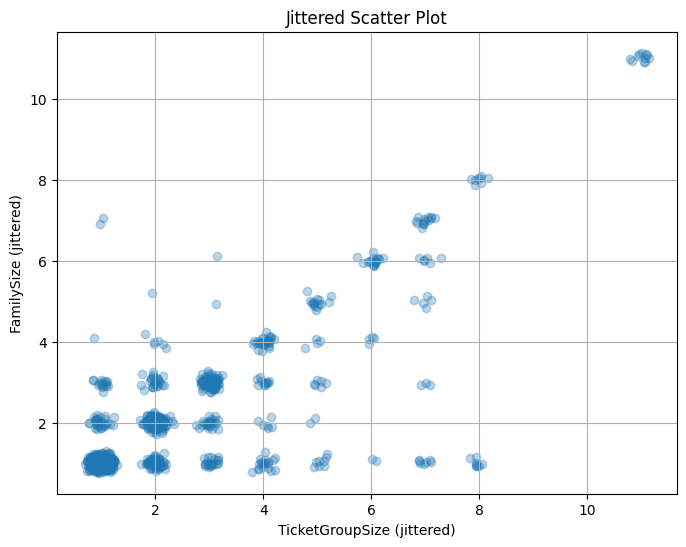

In [3253]:
x = FULL_DATA['TicketGroupSize'] + np.random.normal(0, 0.1, len(FULL_DATA))
y = FULL_DATA['FamilySize'] + np.random.normal(0, 0.1, len(FULL_DATA))

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('TicketGroupSize (jittered)')
plt.ylabel('FamilySize (jittered)')
plt.title('Jittered Scatter Plot')
plt.grid(True)
plt.show()

FamilySize and TicketGroupSize have a strong correlation, but they are not exactly identical.

In [3254]:
# Take the maximum value of FamilySize and TicketGroupSize as a feature
FULL_DATA['GroupSize'] = FULL_DATA[['TicketGroupSize', 'FamilySize']].max(axis=1)
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['GroupSize'])

   GroupSize      mean  count
0          1  0.270089    448
1          2  0.469613    181
2          3  0.606299    127
3          4  0.729167     48
4          5  0.363636     22
5          6  0.250000     20
6          7  0.240000     25
7          8  0.384615     13
8         11  0.000000      7


GroupSize = 8 and 11 seem to be outliers.

In [3255]:
def group_bucket(x):
    if x <= 5:
        return x
    else:
        return 6
    
FULL_DATA['GroupSize'] = FULL_DATA['GroupSize'].apply(group_bucket)
temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['GroupSize'])

   GroupSize      mean  count
0          1  0.270089    448
1          2  0.469613    181
2          3  0.606299    127
3          4  0.729167     48
4          5  0.363636     22
5          6  0.246154     65


In [3256]:
FULL_DATA.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_train', 'Title',
       'Has_Cabin', 'CabinInitial', 'CabinAdvantage', 'FamilySize', 'IsAlone',
       'TicketGroupSize', 'FamilySizeBand', 'TicketGroupSizeBand',
       'GroupSize'],
      dtype='object')

In [ ]:
# In each group, try using the number of male/female passengers

FULL_DATA = FULL_DATA[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_train', 'Title',
       'Has_Cabin', 'CabinInitial', 'CabinAdvantage', 'FamilySize', 'IsAlone', 'TicketGroupSize', 'GroupSize']]

ticket_sex_counts = FULL_DATA.groupby(['Ticket', 'Sex'])['Sex'].count().unstack(fill_value=0)

# merge w.r.t. 'Ticket'
if 'num_male_sametickets' not in FULL_DATA.columns:
    FULL_DATA = FULL_DATA.merge(
        ticket_sex_counts,
        how='left',
        on='Ticket',
        suffixes=('', '_count')
    )

FULL_DATA.rename(columns={'male': 'num_male_sametickets', 'female': 'num_female_sametickets'}, inplace=True)

# Remove oneself from the counts of sametickets
FULL_DATA['num_male_sametickets'] = FULL_DATA['num_male_sametickets'] - (FULL_DATA['Sex'] == 'male').astype(int)
FULL_DATA['num_female_sametickets'] = FULL_DATA['num_female_sametickets'] - (FULL_DATA['Sex'] == 'female').astype(int)
if FULL_DATA.num_male_sametickets.min() < 0:
    raise Exception

FULL_DATA.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Has_Cabin,CabinInitial,CabinAdvantage,FamilySize,IsAlone,TicketGroupSize,GroupSize,num_female_sametickets,num_male_sametickets
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,0,U,1,2,0,1,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,1,C,3,2,0,2,2,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,0,U,1,1,1,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,1,C,3,2,0,2,2,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,0,U,1,1,1,1,1,0,0


In [3258]:
# check new columns
FULL_DATA.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_train', 'Title',
       'Has_Cabin', 'CabinInitial', 'CabinAdvantage', 'FamilySize', 'IsAlone',
       'TicketGroupSize', 'GroupSize', 'num_female_sametickets',
       'num_male_sametickets'],
      dtype='object')

In [3259]:
temp = FULL_DATA[FULL_DATA.is_train==1]
col_list = ['num_male_sametickets', 'num_female_sametickets']
check_survival_rate(temp, col_list)

   num_male_sametickets      mean  count
0                     0  0.323052    616
1                     1  0.616279    172
2                     2  0.500000     56
3                     3  0.142857      7
4                     4  0.066667     15
5                     5  0.200000     10
6                     6  0.000000      8
7                     7  0.714286      7
   num_female_sametickets      mean  count
0                       0  0.317881    604
1                       1  0.598765    162
2                       2  0.513158     76
3                       3  0.379310     29
4                       4  0.214286     14
5                       5  0.000000      6


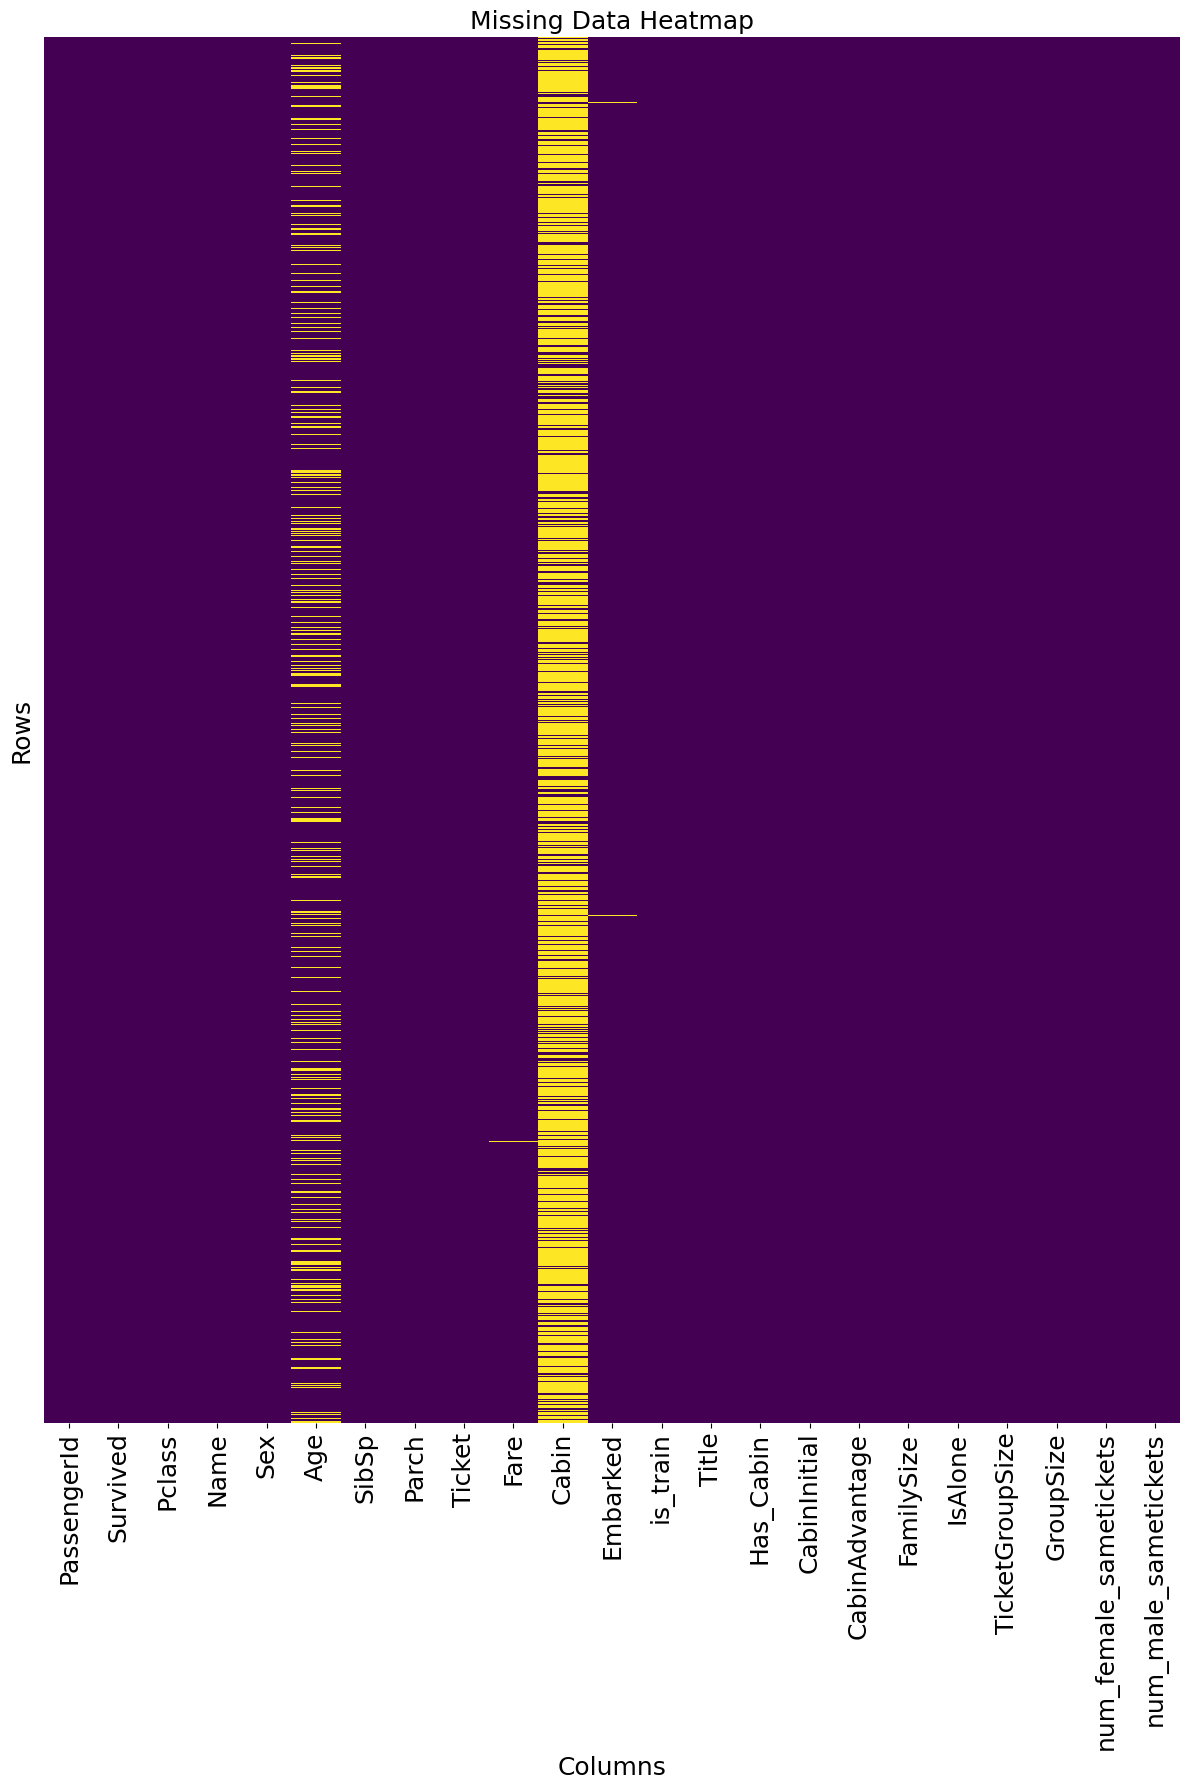

In [3260]:
heatmap_missing_values(FULL_DATA, plotheight=18)

In [3261]:
# fillna() (necessary before applying pd.qcut() or pd.cut())

# To fill empty cells in 'Age', use the average for each 'Title' first,
FULL_DATA['Age'] = FULL_DATA.groupby('Title')['Age'].transform(
    lambda x: x.fillna(x.median())
)
# and if there are still NULL values, fill it with median value of all ages
FULL_DATA['Age'] = FULL_DATA['Age'].fillna(FULL_DATA['Age'].median())


In [3262]:
# 'Embarked', 'Fare' columns have a few empty cells
FULL_DATA['Embarked'] = FULL_DATA['Embarked'].fillna(FULL_DATA['Embarked'].mode()[0])
FULL_DATA['Fare'] = FULL_DATA['Fare'].fillna(FULL_DATA['Fare'].median())


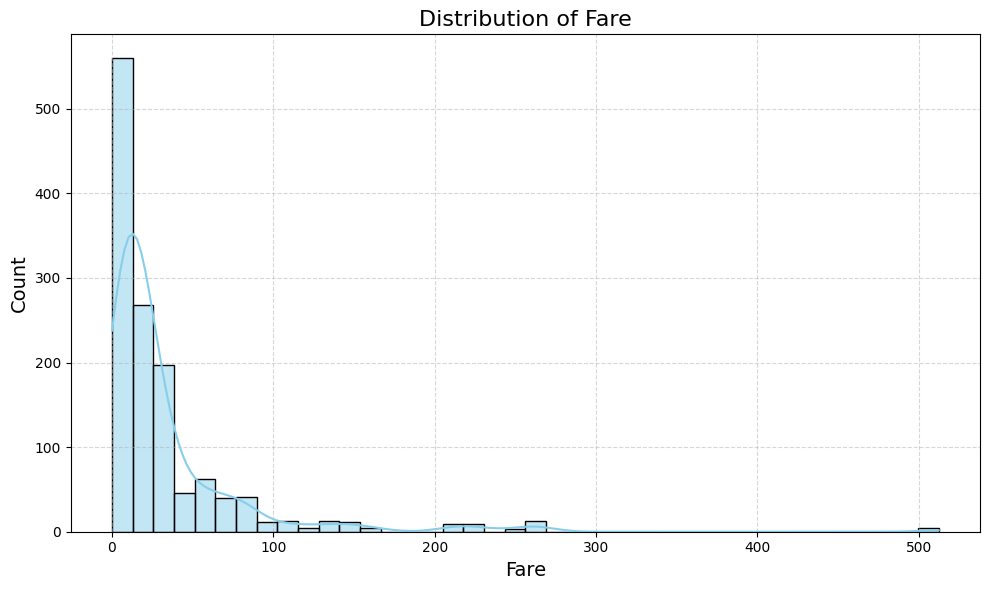

In [3263]:
plt.figure(figsize=(10, 6))
sns.histplot(FULL_DATA['Fare'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Fare', fontsize=16)
plt.xlabel('Fare', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

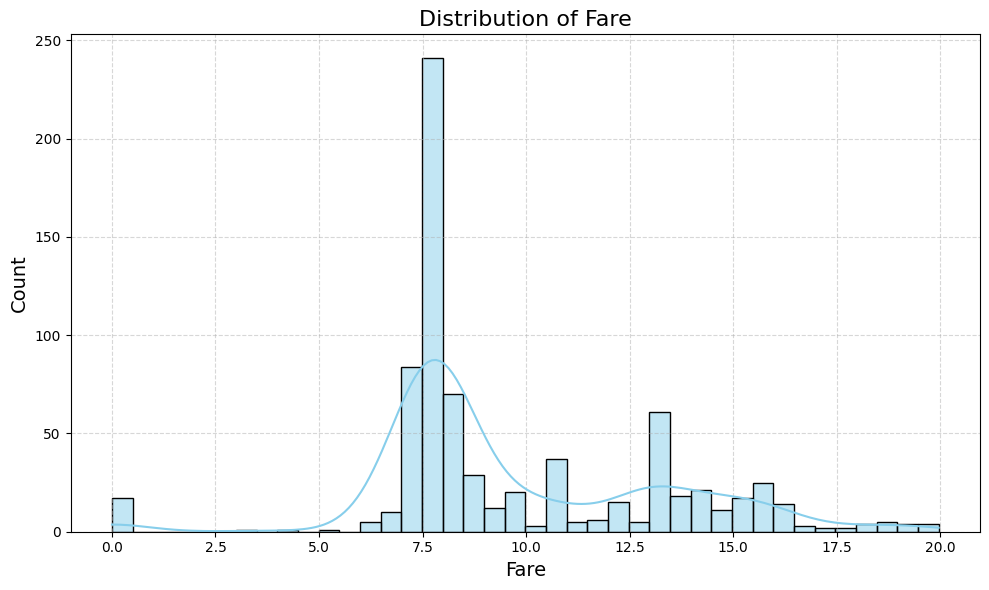

In [3264]:
# refine the previous plot for Fare <= 20
plt.figure(figsize=(10, 6))
df_LowFare = FULL_DATA[FULL_DATA.Fare <= 20]
sns.histplot(df_LowFare['Fare'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Fare', fontsize=16)
plt.xlabel('Fare', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

There are some people whose 'Fare' is less than $6. Who are they? Is the 'Fare' column reliable?

In [3265]:
temp = FULL_DATA[FULL_DATA.Fare < 6]
temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Has_Cabin,CabinInitial,CabinAdvantage,FamilySize,IsAlone,TicketGroupSize,GroupSize,num_female_sametickets,num_male_sametickets
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,...,Mr,0,U,1,1,1,4,4,0,3
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,...,Mr,1,B,4,1,1,1,1,0,0
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,...,Mr,0,U,1,1,1,4,4,0,3
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,29.0,0,0,239853,0.0,...,Mr,0,U,1,1,1,3,3,0,2
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,...,Mr,0,U,1,1,1,4,4,0,3


In [3266]:
# check the survival rate for these group of people.
temp = temp[temp.is_train==1]
check_survival_rate(temp, ['Sex'])

    Sex      mean  count
0  male  0.058824     17


They are all male, all dead except one.

==> This could be a specific group of people. (It's reasonable to keep this group of people separately.)

c:\Users\pkskng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\pkskng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


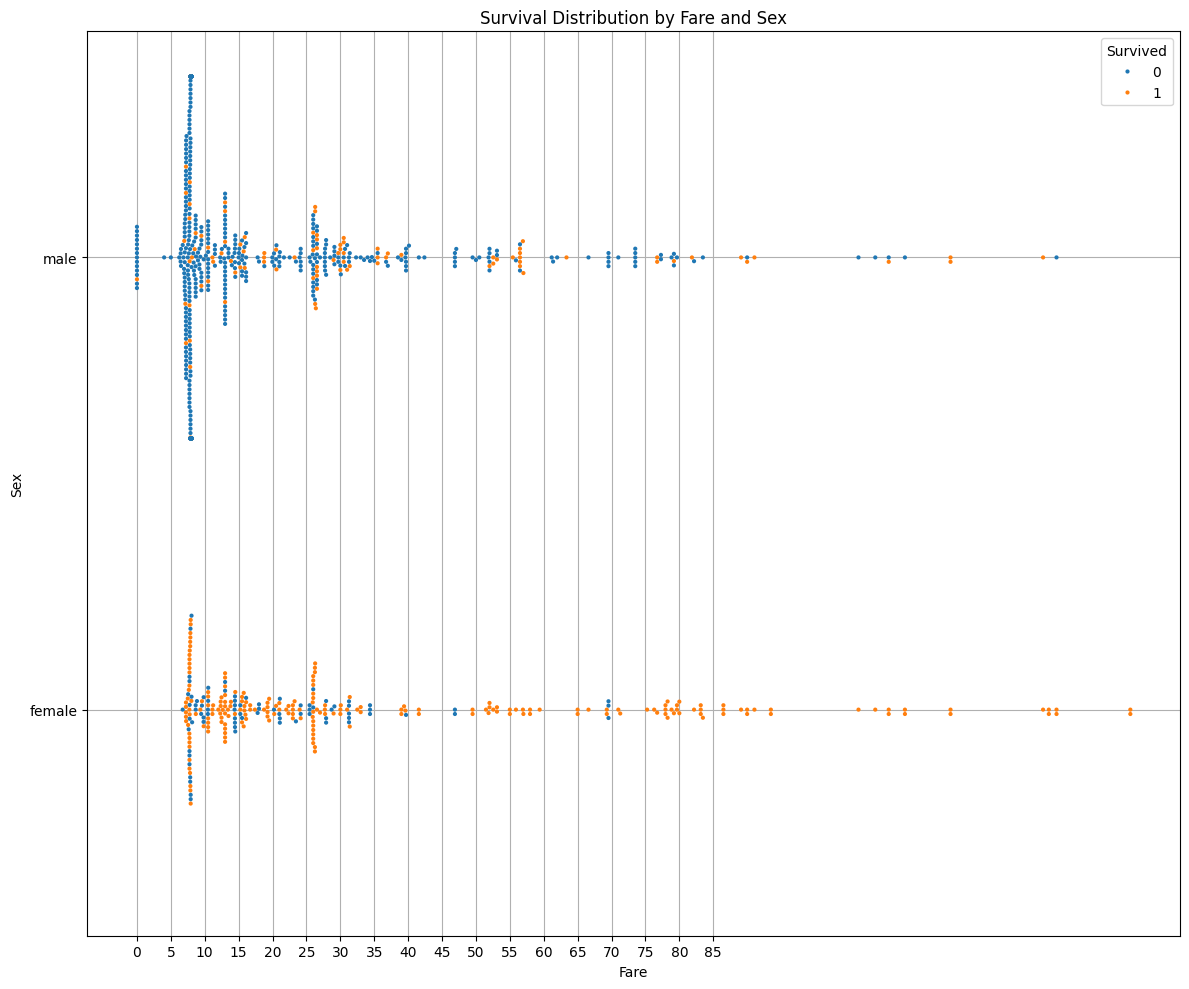

In [3267]:
# Visualize Fare & Sex vs Survival rate

temp = FULL_DATA[FULL_DATA.is_train==1]
temp = temp[temp.Fare < 150]

plt.figure(figsize=(12, 10))
sns.swarmplot(
    data=temp,
    x='Fare',
    y='Sex',
    hue='Survived',
    # palette='Set2',
    # dodge=True,
    size=3
)
plt.title('Survival Distribution by Fare and Sex')
plt.xlabel('Fare')
plt.ylabel('Sex')
plt.legend(title='Survived')
plt.xticks(list(range(0,90,5)))
plt.grid(True)
plt.tight_layout()
plt.show()

In [3268]:
# 'Fare' is spread too wide ==> Add Log(1+x) transformation of Fare
FULL_DATA['FareLog'] = np.log1p(FULL_DATA['Fare'])


In [3270]:
# Define 'FareBand'

df_ZeroFare = FULL_DATA[FULL_DATA.Fare < 6]
df_LowFare = FULL_DATA[FULL_DATA.Fare >= 6]
df_LowFare = df_LowFare[df_LowFare.Fare < 18]
df_HighFare = FULL_DATA[FULL_DATA.Fare >= 18]

df_ZeroFare['FareBand'] = pd.qcut(df_ZeroFare['Fare'], 1)
df_LowFare['FareBand'] = pd.qcut(df_LowFare['Fare'], 4)
df_HighFare['FareBand'] = pd.qcut(df_HighFare['Fare'], 4)
FULL_DATA = pd.concat([df_ZeroFare, df_LowFare, df_HighFare])
FULL_DATA['FareBandMedian'] = FULL_DATA.groupby('FareBand')['Fare'].transform('median')

temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['FareBandMedian'], lengthcap=False)

   FareBandMedian      mean  count
0          0.0000  0.058824     17
1          7.2500  0.227642    123
2          7.8958  0.200000    145
3          9.8396  0.316327     98
4         14.4000  0.379310    116
5         23.4500  0.453608     97
6         29.4125  0.447619    105
7         55.0000  0.473118     93
8        113.2750  0.762887     97


C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\4234021037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ZeroFare['FareBand'] = pd.qcut(df_ZeroFare['Fare'], 1)
C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\4234021037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HighFare['FareBand'] = pd.qcut(df_HighFare['Fare'], 4)


Do the same for Age

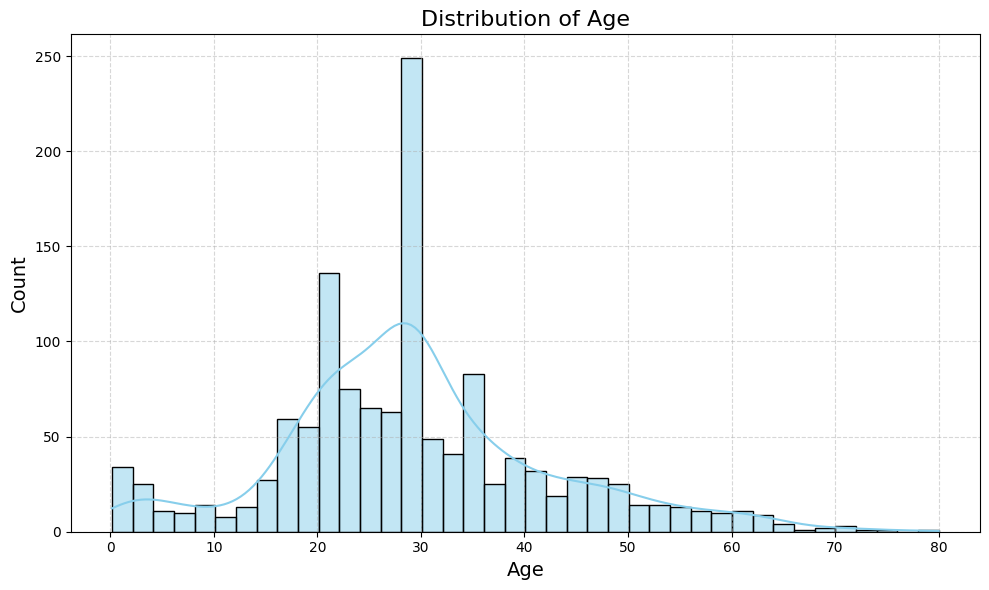

In [3271]:
plt.figure(figsize=(10, 6))
sns.histplot(FULL_DATA['Age'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

c:\Users\pkskng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\pkskng\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


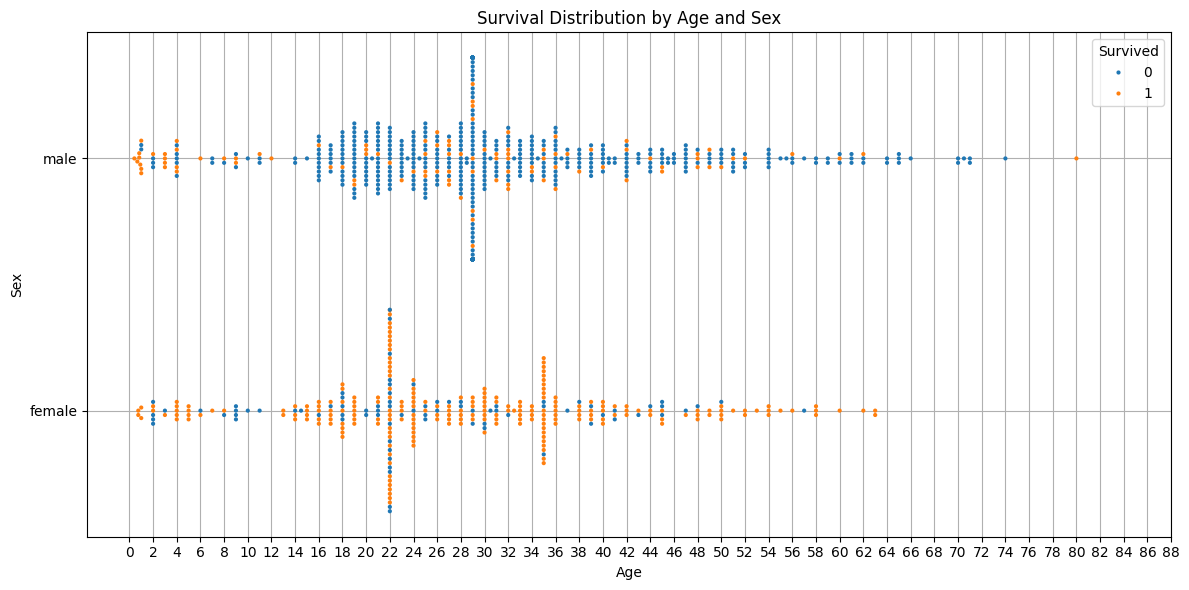

In [3272]:
# check survival rates and sample counts w.r.t. Age
# Visualize samples w.r.t. Age

temp = FULL_DATA[FULL_DATA.is_train==1]

plt.figure(figsize=(12, 6))
sns.swarmplot(
    data=temp,
    x='Age',
    y='Sex',
    hue='Survived',
    # palette='Set2',
    # dodge=True,
    size=3
)
plt.title('Survival Distribution by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Sex')
plt.legend(title='Survived')
plt.xticks(list(range(0,90,2)))
plt.grid(True)
plt.tight_layout()
plt.show()

In [3273]:

df_kids = FULL_DATA[FULL_DATA.Age < 12]
df_adults = FULL_DATA[FULL_DATA.Age >= 12]

# df_kids['AgeBand'] = pd.cut(df_kids['Age'], 2)
df_kids['AgeBand'] = pd.cut(df_kids['Age'], 3)
df_adults['AgeBand'] = pd.cut(df_adults['Age'], 3)

FULL_DATA = pd.concat([df_kids, df_adults])
FULL_DATA['AgeBandMedian'] = FULL_DATA.groupby('AgeBand')['Age'].transform('median')

# print(FULL_DATA['FareBand'].value_counts)
# print(FULL_DATA['AgeBand'].value_counts)

temp = FULL_DATA[FULL_DATA.is_train==1]
check_survival_rate(temp, ['AgeBandMedian'], lengthcap=False)

   AgeBandMedian      mean  count
0            1.0  0.666667     30
1            4.0  0.666667     24
2            9.0  0.277778     18
3           26.0  0.340989    566
4           42.0  0.445455    220
5           62.0  0.303030     33


C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\3032485912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kids['AgeBand'] = pd.cut(df_kids['Age'], 3)
C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\3032485912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adults['AgeBand'] = pd.cut(df_adults['Age'], 3)


In [3274]:
# Determine if he/she is caring a baby or a kid

# 1. create 'is_kid' column (Age < 7)
FULL_DATA['is_kid'] = (FULL_DATA['Age'] < 7).astype(int)

# 2. Count number of kids for each ticket number
kids_per_ticket = FULL_DATA.groupby('Ticket')['is_kid'].sum()

# 3. Add 'num_kids_sametickets' column to FULL_DATA (exclude oneself)
FULL_DATA['num_kids_sametickets'] = FULL_DATA['Ticket'].map(kids_per_ticket) - FULL_DATA.is_kid
# 3. Add 'with_kids' column to FULL_DATA
FULL_DATA['with_kids'] = (FULL_DATA['num_kids_sametickets'] > 0).astype(int)


In [3275]:
# check
females = FULL_DATA[FULL_DATA.is_train==1][FULL_DATA.Sex=='female']
males = FULL_DATA[FULL_DATA.is_train==1][FULL_DATA.Sex=='male']
check_survival_rate(females, ['with_kids'])
check_survival_rate(males, ['with_kids'])

   with_kids      mean  count
0          0  0.796875    256
1          1  0.500000     58
   with_kids      mean  count
0          0  0.180451    532
1          1  0.288889     45


C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\2871333114.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  females = FULL_DATA[FULL_DATA.is_train==1][FULL_DATA.Sex=='female']
C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\2871333114.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  males = FULL_DATA[FULL_DATA.is_train==1][FULL_DATA.Sex=='male']


Female passengers whose ticket number is shared with a kid (Age < 7) has lower survival rates than other female passengers.

For male passengers, it is the opposite.

In [3276]:
# Divide male/female, with/without kids into 4 categories

females = FULL_DATA[FULL_DATA.Sex=='female']
males = FULL_DATA[FULL_DATA.Sex=='male']
females['with_kids_case'] = females['with_kids'] + 2
males['with_kids_case'] = males['with_kids']
FULL_DATA = pd.concat([females, males])

FULL_DATA['with_kids_case'] = (FULL_DATA['with_kids_case']).astype('int64')

C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\736583238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  females['with_kids_case'] = females['with_kids'] + 2
C:\Users\pkskng\AppData\Local\Temp\ipykernel_151516\736583238.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males['with_kids_case'] = males['with_kids']


In [3277]:
FULL_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 10 to 1298
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype                   
---  ------                  --------------  -----                   
 0   PassengerId             1309 non-null   int64                   
 1   Survived                1309 non-null   int64                   
 2   Pclass                  1309 non-null   int64                   
 3   Name                    1309 non-null   object                  
 4   Sex                     1309 non-null   object                  
 5   Age                     1309 non-null   float64                 
 6   SibSp                   1309 non-null   int64                   
 7   Parch                   1309 non-null   int64                   
 8   Ticket                  1309 non-null   object                  
 9   Fare                    1309 non-null   float64                 
 10  Cabin                   295 non-null    object 

In [3287]:
# Complex relationships may be captured in combined features

# First moment
FULL_DATA['Age_FareLog'] = FULL_DATA['Age'] * FULL_DATA['FareLog']
FULL_DATA['Age_Fare'] = FULL_DATA['Age'] * FULL_DATA['Fare']
FULL_DATA['Age_Pclass'] = FULL_DATA['Age'] * FULL_DATA['Pclass']
FULL_DATA['Age_FamilySize'] = FULL_DATA['Age'] * FULL_DATA['FamilySize']
FULL_DATA['Age_GroupSize'] = FULL_DATA['Age'] * FULL_DATA['GroupSize']

# Second moment
FULL_DATA['Age_FareLogSquared'] = FULL_DATA['Age'] * FULL_DATA['FareLog'] * FULL_DATA['FareLog']
FULL_DATA['AgeSquared_FareLog'] = FULL_DATA['Age'] * FULL_DATA['Age'] * FULL_DATA['FareLog']
FULL_DATA['FareBandMedianSquared'] = FULL_DATA['FareBandMedian'] * FULL_DATA['FareBandMedian']

# Reciprocal
FULL_DATA['FarelogOverAge'] = FULL_DATA['FareLog'] / (FULL_DATA['Age']+1)

# FamilySize * TicketGroupSize
FULL_DATA['Family_TicketGroup'] = FULL_DATA['FamilySize'] * FULL_DATA['TicketGroupSize']


#####################################

Machine Learning

#####################################

In [3288]:
# reserve passenger_id, is_train, survived for tagging
full_passenger_ids = FULL_DATA['PassengerId']
full_is_train = FULL_DATA['is_train']
full_survived = FULL_DATA['Survived']


In [3289]:
# Scale numeric columns

FULL_DATA_normalized = FULL_DATA.copy()
col_list_numeric = FULL_DATA_normalized.select_dtypes(include=['float64', 'int64']).columns
df_mean = FULL_DATA_normalized[col_list_numeric].mean(axis=0)
df_std = FULL_DATA_normalized[col_list_numeric].std(axis=0)
FULL_DATA_normalized[col_list_numeric] = (FULL_DATA_normalized[col_list_numeric] - df_mean) / df_std

In [3290]:
FULL_DATA_normalized.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_train', 'Title',
       'Has_Cabin', 'CabinInitial', 'CabinAdvantage', 'FamilySize', 'IsAlone',
       'TicketGroupSize', 'GroupSize', 'num_female_sametickets',
       'num_male_sametickets', 'FareLog', 'FareBand', 'FareBandMedian',
       'AgeBand', 'AgeBandMedian', 'is_kid', 'num_kids_sametickets',
       'with_kids', 'with_kids_case', 'Age_FareLog', 'Age_Fare', 'Age_Pclass',
       'Age_FamilySize', 'Age_GroupSize', 'Age_FareLogSquared',
       'AgeSquared_FareLog', 'FareBandMedianSquared', 'FarelogOverAge',
       'Family_TicketGroup'],
      dtype='object')

## 🧪 Feature Selection Process for Titanic Survival Prediction

Through extensive experimentation, I explored various feature combinations to optimize the performance of an ensemble model for the Titanic dataset. The goal was to identify the most informative and predictive set of features based on both domain knowledge and empirical results.

### 🔄 Iterative Testing

I tested over **30 different feature sets**, gradually refining the variables by:
- Evaluating feature interactions (e.g., `Age_FareLog`, `Age_Pclass`)
- Comparing raw vs. transformed features (`Fare` vs. `FareLog`, `Age` vs. `AgeBandMedian`)
- Incorporating family and ticket group metrics (`FamilySize`, `TicketGroupSize`, `IsAlone`)
- Engineering new compound features (e.g., `with_kids`, `FarelogOverAge`, `GroupSize`)

During this process, I tracked:
- **Validation accuracy** (on 80% of training data)
- **Public leaderboard score** on Kaggle submissions

Notable insights:
- Using `Fare` instead of `FareLog` improved the final score.
- `GroupSize` (max of `FamilySize` and `TicketGroupSize`) showed a non-monotonic relationship with survival, so I retained both original features.
- Some features (e.g., `CabinInitial`, `with_kids_case`, `FarelogOverAge`) improved validation accuracy but did not generalize well on the test set.

---

### ✅ Final Feature Set

After testing, the following features yielded the **highest score of 0.78947** on the public leaderboard with 80% of training data used:

```python
features = ['Pclass', 'Fare', 'Title', 'FamilySize', 'TicketGroupSize', 'Age_Fare', 'Age_Pclass']


📌 Notes:
Fare and Age_Fare outperformed their logarithmic counterparts (FareLog, Age_FareLog)

Combining raw numerical features with interaction terms (Age_Pclass) improved model robustness

Ensemble models responded well to interpretable, non-binned features

⚠️ 80% Training Data Outperformed 100% in terms of Kaggle leaderboard score (0.78947 vs 0.77990).
This could be due to several factors:

Overfitting on the full training set: With more data, especially noisy or less relevant samples, the model may have started to overfit and thus generalized worse to the test set.

Better hyperparameter generalization: The 80% split may have accidentally aligned better with the test set distribution, acting as an implicit form of regularization.

Validation alignment: The 80% split used for validation may have given feedback that more closely resembled the actual test set structure.

In [3312]:
# Select features to train models

features = ['Pclass', 'Fare', 'Title', 'FamilySize', 'TicketGroupSize', 'Age_Fare', 'Age_Pclass'] # 80% data, 0.8324 on TRAIN_validation, Score 0.78947(model: ensemble)


In [3313]:

full_data_wide = pd.get_dummies(FULL_DATA_normalized[features])
full_data_wide['PassengerId'] = full_passenger_ids
full_data_wide['is_train'] = full_is_train
full_data_wide['Survived'] = full_survived

full_data_wide.head(2)

full_data_wide.columns

features_wide = full_data_wide.columns.to_list()
features_wide.remove('PassengerId')
features_wide.remove('is_train')
features_wide.remove('Survived')
# features_wide


#####################################

Separate train/test

#####################################

In [3314]:

TRAIN_DATA = full_data_wide[full_data_wide['is_train'] == 1]
train_passenger_ids = TRAIN_DATA['PassengerId']

TEST_DATA = full_data_wide[full_data_wide['is_train'] == 0]
test_passenger_ids = TEST_DATA['PassengerId']

TRAIN_DATA.columns

Index(['Pclass', 'Fare', 'FamilySize', 'TicketGroupSize', 'Age_Fare',
       'Age_Pclass', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Title_Rev', 'PassengerId', 'is_train',
       'Survived'],
      dtype='object')

In [3315]:
#####################################
# Value Selection to reduce complexity and overfitting
# manually choose which values to use and which values to neglect
#####################################

# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel

X = TRAIN_DATA[features_wide]
Y = TRAIN_DATA['Survived']


In [3316]:

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, Y)

# selector = SelectKBest(score_func=f_classif, k=10) # linear correlation based
# X_selected = selector.fit_transform(X, TRAIN_DATA['Survived']) # linear correlation based
selector = SelectFromModel(rf, prefit=True, threshold='median')
X_selected = selector.transform(X)

# 선택된 컬럼명 확인
selected_columns = X.columns[selector.get_support()]
print(selected_columns)


Index(['Pclass', 'Fare', 'FamilySize', 'Age_Fare', 'Age_Pclass', 'Title_Mr',
       'Title_Mrs'],
      dtype='object')


c:\Users\pkskng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


The above 'selected_columns' may be used to discard some of the values of feature columns, by setting apply_selected_columns to TRUE. If not, all the columns in features_wide will be used.

#####################################

Check accuracies of various models before optimization

#####################################

In [ ]:

if apply_selected_columns == True:
    X = TRAIN_DATA[selected_columns]
    X_test = TEST_DATA[selected_columns]
else:
    X = TRAIN_DATA[features_wide]
    X_test = TEST_DATA[features_wide]


Y = TRAIN_DATA['Survived']

seed = 7
scoring = 'accuracy'
validation_size = 0.20 # After several trials, 0.20 is likely an optimal choice
# X_TRAIN_train, X_TRAIN_validation, Y_TRAIN_train, Y_TRAIN_validation = model_selection.train_test_split(X,Y, test_size=validation_size, random_state=seed)
X_TRAIN_train, X_TRAIN_validation, Y_TRAIN_train, Y_TRAIN_validation, pid_train, pid_val = model_selection.train_test_split(X,Y, train_passenger_ids, test_size=validation_size, random_state=seed)


In [3319]:
# Run this cell only after the final model is fixed and it's about to be submited.
if final_fit == True:
    X_TRAIN_train = X.copy()
    X_TRAIN_validation = X.copy()
    Y_TRAIN_train = Y.copy()
    Y_TRAIN_validation = Y.copy()
    pid_train = train_passenger_ids
    pid_validation = train_passenger_ids


In [3321]:
print(len(X), len(X_TRAIN_train))

891 712


In [ ]:
# Spot Check Algorithms
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier(random_state=42)))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM', SVC(probability=True)))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    try:
        # kfold = model_selection.KFold(n_splits=10, random_state = seed)
        kfold = model_selection.KFold(n_splits=10, random_state = None)
        cv_results = model_selection.cross_val_score(model, X_TRAIN_train, Y_TRAIN_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        # print(msg)
        # print(cv_results)
    except:
        pass


# Accuracy scores
print('[Model : Accuracy score]\n')
outputs = []
for i in range(len(models)):
    model = models[i][1]
    model.fit(X_TRAIN_train,Y_TRAIN_train)
    predictions = model.predict(X_TRAIN_validation)

    output = pd.DataFrame({
        'PassengerId': pid_val,
        'predictioin': predictions,
        'Survived': Y_TRAIN_validation
    })
    outputs.append(output)

    print(models[i][0], ':', accuracy_score(Y_TRAIN_validation, predictions))


#####################################

Tune Hyper Parameters for 

- Random Forest Classifier
- Gradient Boosting Classifier
- Support Vector Machine
- Logistic Regression

#####################################

In [3300]:
# for RandomForest Classifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 16, 32],
    'min_samples_split': [2, 4, 8]
}
RF = RandomForestClassifier(random_state=42)
grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy')
# grid.fit(X_TRAIN_train, Y_TRAIN_train)
grid.fit(X, Y)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

RF_optimal = grid.best_estimator_

Best score: 0.7444542087753436
Best params: {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 100}


In [3301]:
# for GradientBoostingClassifier

param_grid = {
    # 'n_estimators': [100, 200, 300],       # 트리 개수
    'n_estimators': [300],       # 트리 개수
    # 'learning_rate': [0.01, 0.05, 0.1],    # 학습률
    'learning_rate': [0.01],    # 학습률
    # 'max_depth': [3, 4, 5],                # 각 트리의 최대 깊이
    'max_depth': [4],                # 각 트리의 최대 깊이
    # 'min_samples_split': [2, 5, 10],       # 내부 노드 분할 최소 샘플 수
    'min_samples_split': [10],       # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 3, 5],         # 리프 노드 최소 샘플 수
    'subsample': [0.8, 1.0]                # 각 트리에 사용할 데이터 비율 (bagging 효과)
}
GB = GradientBoostingClassifier(random_state=42)
# GridSearchCV 객체 생성
grid = GridSearchCV(estimator=GB, param_grid=param_grid,
                    scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# 모델 학습
# grid.fit(X_TRAIN_train, Y_TRAIN_train)
grid.fit(X, Y)

# 결과 출력
print("Best Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# 최적 모델 추출
GB_optimal = grid.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Score: 0.7691544786893478
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.8}


In [3302]:
# for Support Vector Machine

# SVM은 feature scale에 민감하므로 반드시 표준화 필요!
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

# 하이퍼파라미터 그리드
param_grid = {
    'svc__C': [0.1, 1, 10],              # 정규화 파라미터 (오차 허용도)
    'svc__gamma': [0.01, 0.1, 1],        # RBF 커널에서 결정 경계의 곡률
    'svc__kernel': ['rbf']              # 일반적으로 RBF 커널이 가장 성능 좋음
}

# GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 학습
# grid.fit(X_TRAIN_train, Y_TRAIN_train)
grid.fit(X, Y)

# 결과 확인
print("Best Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# 최적 모델 추출
SVC_optimal = grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score: 0.7657836921724939
Best Parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [3303]:
# for Logistic Regression

# 파이프라인: 스케일러 + 로지스틱 회귀
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))  # solver 선택 중요!
])

# 하이퍼파라미터 후보
param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],        # 규제 강도 (작을수록 강한 규제)
    'lr__penalty': ['l1', 'l2'],             # L1: 특성 선택 효과, L2: 일반적 정규화
    'lr__solver': ['liblinear']              # L1 지원하는 solver (liblinear만 가능)
}

# GridSearchCV 정의
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 학습
# grid.fit(X_TRAIN_train, Y_TRAIN_train)
grid.fit(X, Y)

# 결과 확인
print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)

# 최적 모델 추출
LR_optimal = grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.7815140292511455
Best Params: {'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [3304]:
# Check RF, GB, SVC, LR accuracy after optimization
print('Accuracy Scores:')

RF_optimal.fit(X_TRAIN_train, Y_TRAIN_train)
predictions = RF_optimal.predict(X_TRAIN_validation)
accuracy_score_RF = accuracy_score(Y_TRAIN_validation, predictions)
print('RF', ':', accuracy_score_RF)

GB_optimal.fit(X_TRAIN_train, Y_TRAIN_train)
predictions = GB_optimal.predict(X_TRAIN_validation)
accuracy_score_GB = accuracy_score(Y_TRAIN_validation, predictions)
print('GB', ':', accuracy_score_GB)

SVC_optimal.fit(X_TRAIN_train, Y_TRAIN_train)
predictions = SVC_optimal.predict(X_TRAIN_validation)
accuracy_score_SVC = accuracy_score(Y_TRAIN_validation, predictions)
print('SVC', ':', accuracy_score_SVC)

LR_optimal.fit(X_TRAIN_train, Y_TRAIN_train)
predictions = LR_optimal.predict(X_TRAIN_validation)
accuracy_score_LR = accuracy_score(Y_TRAIN_validation, predictions)
print('LR', ':', accuracy_score_LR)

Accuracy Scores:
RF : 0.8100558659217877
GB : 0.8156424581005587
SVC : 0.7932960893854749
LR : 0.7821229050279329


In [3305]:
# Model Ensemble
# Choose models with different characteristics

ensemble = VotingClassifier(
    estimators=[
        ('RF', RF_optimal),
        ('GB', GB_optimal),
        ('SVM', SVC_optimal),
        ('LR', LR_optimal)
    ],
    voting='soft'  # soft voting이 성능 더 좋음
)

ensemble.fit(X_TRAIN_train, Y_TRAIN_train)
ensemble_preds = ensemble.predict(X_TRAIN_validation)
accuracy_score_ensemble =  accuracy_score(Y_TRAIN_validation, ensemble_preds)
print('Accuracy (ensemble)', ':', accuracy_score_ensemble)


Accuracy (ensemble) : 0.8156424581005587


In [3306]:
# Model Ensemble (take 2)
# Choose models with different characteristics

ensemble_take2 = VotingClassifier(
    estimators=[
        ('RF', RF_optimal),
        ('GB', GB_optimal),
        ('LR', LR_optimal)
    ],
    voting='soft'  # soft voting이 성능 더 좋음
)

ensemble_take2.fit(X_TRAIN_train, Y_TRAIN_train)
ensemble_preds = ensemble_take2.predict(X_TRAIN_validation)
accuracy_score_ensemble_take2 =  accuracy_score(Y_TRAIN_validation, ensemble_preds)
print('Accuracy (ensemble_take2)', ':', accuracy_score_ensemble_take2)


Accuracy (ensemble_take2) : 0.8100558659217877


In [3307]:
# Model Stacking

base_models = [
    ('rf', RF_optimal),
    ('gb', GB_optimal),
    ('svc', SVC_optimal)
]
# meta_model = LogisticRegression()
meta_model = LR_optimal

stacked = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacked.fit(X_TRAIN_train, Y_TRAIN_train)
stacked_preds = stacked.predict(X_TRAIN_validation)
accuracy_score_stacked = accuracy_score(Y_TRAIN_validation, stacked_preds)

print('Accuracy (stacked)', ':', accuracy_score_stacked)

Accuracy (stacked) : 0.7988826815642458


In [3308]:
# Model Stacking (take 2)

base_models = [
    ('gb', GB_optimal),
]
# meta_model = LogisticRegression()
meta_model = LR_optimal

stacked_take2 = StackingClassifier(estimators=base_models, final_estimator=meta_model)

stacked_take2.fit(X_TRAIN_train, Y_TRAIN_train)
stacked_preds = stacked_take2.predict(X_TRAIN_validation)
accuracy_score_stacked_take2 = accuracy_score(Y_TRAIN_validation, stacked_preds)

print('Accuracy (stacked_take2)', ':', accuracy_score_stacked_take2)

Accuracy (stacked_take2) : 0.7877094972067039


# Export predictions on the test data

In [ ]:
predictions = RF_optimal.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_RF_optimal.csv', index=False)

predictions = GB_optimal.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_GB_optimal.csv', index=False)

predictions = LR_optimal.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_LR_optimal.csv', index=False)

predictions = SVC_optimal.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_SVC_optimal.csv', index=False)

predictions = ensemble.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_ensemble.csv', index=False)

predictions = ensemble_take2.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_ensemble_take2.csv', index=False)

predictions = stacked.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_stacked.csv', index=False)

predictions = stacked_take2.predict(X_test)
output = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions,
})
output.to_csv('submission_stacked_take2.csv', index=False)

In [3310]:
# Check accuracies of each model

print("We have following models / accuracies:")
print('RF_optimal :', accuracy_score_RF)
print('GB_optimal :', accuracy_score_GB)
print('SVC_optimal :', accuracy_score_SVC)
print('LR_optimal :', accuracy_score_LR)
print('ensemble :', accuracy_score_ensemble)
print('stacked :', accuracy_score_stacked)
print('ensemble_take2 :', accuracy_score_ensemble_take2)
print('stacked_take2:', accuracy_score_stacked_take2)

print('features = ', features)

We have following models / accuracies:
RF_optimal : 0.8100558659217877
GB_optimal : 0.8156424581005587
SVC_optimal : 0.7932960893854749
LR_optimal : 0.7821229050279329
ensemble : 0.8156424581005587
stacked : 0.7988826815642458
ensemble_take2 : 0.8100558659217877
stacked_take2: 0.7877094972067039
features =  ['Pclass', 'Fare', 'Title', 'FamilySize', 'TicketGroupSize', 'Age_Fare', 'Age_Pclass']
